In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', 100) # to display all columns at all time
pd.options.mode.chained_assignment = None # to ignore false-positive warnings about chained assignments


In [2]:
data = pd.read_csv('ElectionsData.csv', header=0)
data_copy = data.copy() # clean copy of the data, will be kept wihout any manipulation

Let's see what we're working with:

In [3]:
data.head(10)

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Most_Important_Issue,Avg_Residancy_Altitude,Looking_at_poles_results,Yearly_ExpensesK,Married,Gender,Voting_Time,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,Avg_Satisfaction_with_previous_vote,Avg_monthly_income_all_years,%Time_invested_in_work,Yearly_IncomeK,Avg_monthly_expense_on_pets_or_plants,Avg_monthly_household_cost,Will_vote_only_large_party,Phone_minutes_10_years,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Garden_sqr_meter_per_person_in_residancy_area,Last_school_grades,Age_group,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Overall_happiness_score,Num_of_kids_born_last_10_years,Financial_agenda_matters
0,Yellows,9.0,901.074249,174664.625237,Education,300.358083,No,581.521308,No,Male,After_16:00,0.920727,0.100484,4.365483,2.161798,5.962218,6.106218,9204.0,53.981652,622.909384,7061.031848,80356.465721,Yes,338167.031649,24.958153,7.775210e+05,43.518864,90525.336049,100.0,45_and_up,1.0,1067.419550,14.0,Motorcycle_or_truck,Industry_or_other,897.297947,0.0,No
1,Reds,4.0,172.175470,23146.728293,Education,57.391823,No,403.310559,Yes,Female,By_16:00,0.502451,0.540302,3.046957,6.447056,1.486424,6.706155,6238.0,63.899160,710.857600,5454.820791,83550.459496,Yes,162659.407111,26.661913,1.011912e+06,45.259922,3361.213190,100.0,30-45,0.0,1111.093591,10.0,Public_or_other,Industry_or_other,861.981391,0.0,No
2,Whites,3.0,408.262789,97198.945759,Foreign_Affairs,136.087596,No,714.238096,No,Male,By_16:00,0.899025,0.053332,4.178738,1.761754,3.059453,9.383902,3912.0,29.626594,865.494572,8873.370105,100227.594707,Yes,510136.057819,29.419289,1.499705e+06,25.612407,18665.921495,40.0,30-45,1.0,1260.064170,20.0,Public_or_other,Public_Sector,819.390492,1.0,Yes
3,Blues,4.0,401.755874,52952.486970,Financial,133.918625,No,395.407936,Yes,Male,By_16:00,0.778608,0.845698,3.218688,4.677225,3.427241,0.746178,4040.0,48.221850,562.297360,5078.674075,65151.482447,Yes,156347.435485,23.712810,6.333466e+05,39.306687,18078.116698,60.0,30-45,3.0,837.907521,5.0,Car,Industry_or_other,584.598207,1.0,No
4,Blues,5.0,210.935361,29798.270086,Healthcare,70.311787,No,423.801917,Yes,Female,By_16:00,0.278861,0.654061,3.454708,0.886536,1.984614,1.858172,9276.0,78.740853,577.028056,5392.075284,67056.617613,Yes,179608.065018,24.021408,6.669518e+05,17.378412,5024.059163,80.0,30-45,2.0,859.308498,4.0,Motorcycle_or_truck,Services_or_Retail,595.206111,1.0,No
5,Yellows,1.0,245.727791,34939.741843,Financial,81.909264,No,426.566426,Yes,Female,After_16:00,0.956243,0.698686,0.175241,6.287463,3.886282,8.237665,4742.0,37.631324,520.626097,5306.916451,61232.104508,Yes,181958.915515,22.817232,5.430757e+05,3.325105,6801.036742,60.0,Below_30,3.0,779.272032,1.0,Car,Hightech,536.103805,0.0,No
6,Oranges,3.0,176.199132,20881.681123,Education,58.733044,No,355.535483,Yes,Male,By_16:00,0.216134,0.425945,9.580903,6.754966,6.262171,1.593651,9754.0,16.757709,531.117152,4617.589132,65271.724476,Yes,126405.479608,23.045979,5.652641e+05,64.067057,3518.303489,100.0,45_and_up,1.0,877.433966,18.0,Public_or_other,Services_or_Retail,727.749963,0.0,No
7,Greys,4.0,658.354759,148173.767645,Financial,219.451586,No,675.200258,No,Female,By_16:00,0.975477,0.066626,0.334810,4.534706,5.815745,0.664623,5166.0,50.794958,614.771717,7981.546012,75803.304283,Yes,455895.388013,24.794590,7.572321e+05,32.645866,48388.450329,60.0,Below_30,0.0,950.013756,10.0,Foot_or_bicycle,Industry_or_other,658.398370,5.0,No
8,Browns,8.0,1207.000512,152141.832727,Financial,402.333504,Yes,378.148554,Yes,Male,After_16:00,0.789854,0.037650,3.168378,9.579997,2.597317,9.785732,7634.0,55.871403,790.938181,5363.361902,89437.082515,No,142996.328866,28.123623,1.252413e+06,94.871960,162284.581896,60.0,Below_30,5.0,1178.648405,15.0,Motorcycle_or_truck,Industry_or_

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
Vote                                             10000 non-null object
Occupation_Satisfaction                          9933 non-null float64
Avg_monthly_expense_when_under_age_21            9935 non-null float64
AVG_lottary_expanses                             9936 non-null float64
Most_Important_Issue                             9968 non-null object
Avg_Residancy_Altitude                           9946 non-null float64
Looking_at_poles_results                         9975 non-null object
Yearly_ExpensesK                                 9932 non-null float64
Married                                          9966 non-null object
Gender                                           9967 non-null object
Voting_Time                                      9976 non-null object
Financial_balance_score_(0-1)                    9943 non-null float64
%Of_Household_Income                         

# Attribute Types


Let's see what we're dealing with:

In [5]:
def count_categories(attr):
    return len(data[attr].astype('category').cat.categories)

obj_attr = [(col, count_categories(col))  for col in data if data[col].dtype==np.object]
obj_attr_names = map(lambda x: x[0], obj_attr)
for attr, cnt in obj_attr:
    print "%-30s %5d %s" % (attr,cnt, "BINARY" if cnt==2 else "")

Vote                              10 
Most_Important_Issue               8 
Looking_at_poles_results           2 BINARY
Married                            2 BINARY
Gender                             2 BINARY
Voting_Time                        2 BINARY
Will_vote_only_large_party         2 BINARY
Age_group                          3 
Main_transportation                4 
Occupation                         5 
Financial_agenda_matters           2 BINARY


Great! out of 10K rows, all attributes have a very small amount of distinct values,
meaning they are ALL categorical, and 6 of them are binary.

We'll transform them to __categorical__, for now.

In [6]:
for attr, cnt in obj_attr:
        data[attr] = data[attr].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
Vote                                             10000 non-null category
Occupation_Satisfaction                          9933 non-null float64
Avg_monthly_expense_when_under_age_21            9935 non-null float64
AVG_lottary_expanses                             9936 non-null float64
Most_Important_Issue                             9968 non-null category
Avg_Residancy_Altitude                           9946 non-null float64
Looking_at_poles_results                         9975 non-null category
Yearly_ExpensesK                                 9932 non-null float64
Married                                          9966 non-null category
Gender                                           9967 non-null category
Voting_Time                                      9976 non-null category
Financial_balance_score_(0-1)                    9943 non-null float64
%Of_Household_Income             

# Imputation
As we can see from data.info(), all attributes have missing values.
The most naive thing to do is simply remove the rows with the missing values. This, of course, will make us lose data.
One advantage to this though is that it guarantees that all data is legitimate and not inferred in any way.

Let's see how many data rows we'd lose that way:

In [7]:
def get_nan_per_row_counter():
    return Counter(data.isnull().sum(axis=1).tolist())

def plot_pie_nan_per_row():
    counter = get_nan_per_row_counter()
    labels, histogram = zip(*counter.most_common())
    fig1, ax1 = plt.subplots()
    ax1.pie(histogram, labels=labels,
            colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral'],
            explode = [0.1] * len(histogram),
            autopct = lambda(p): '{:.0f}  ({:.2f}%)'.format(p * sum(histogram) / 100, p)
           )
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

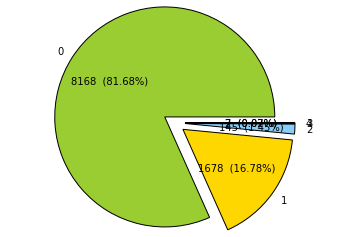

In [8]:
plot_pie_nan_per_row()

As the pie-chart demonstrates, we'd lose almost 20% of our data, which is more than we can afford.

we can also see the vast majority of rows have almost-complete data, meaning that keeping them all and filling out all missing values will maintain a high per-row credibility.

So that is what we will do! (This is also what we have to do, because this is what the assignment says...)
We now have to impute every single missing data-piece, using the methods we learned in class.

## Class-Restricted observations:

We found some strong connections between the "Vote" and some of the categorical attributes.
This is great because the "Vote" is present in all rows.

Let's observe the distribution of different attributes, with respect to __Vote__:

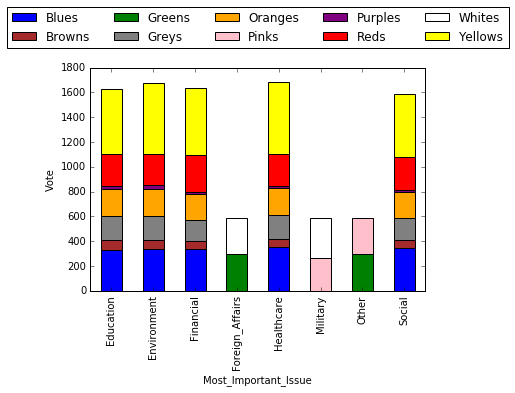

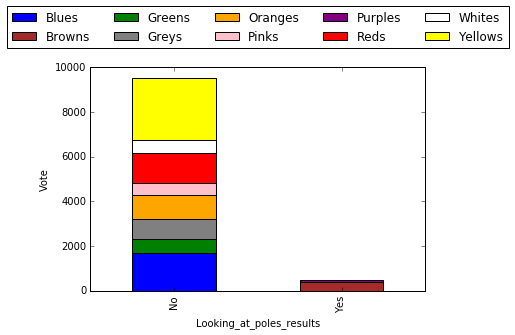

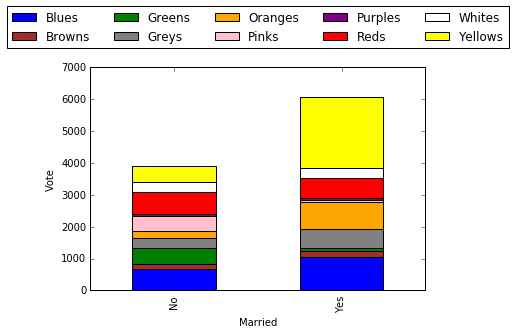

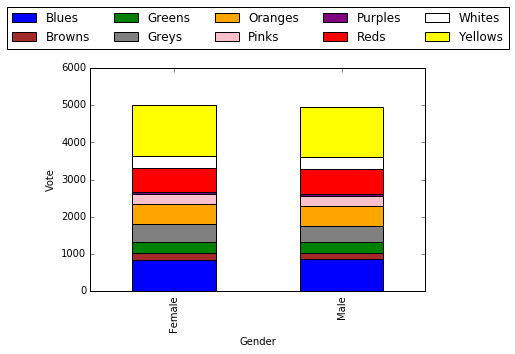

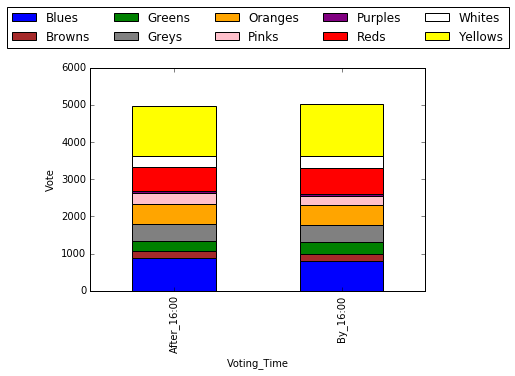

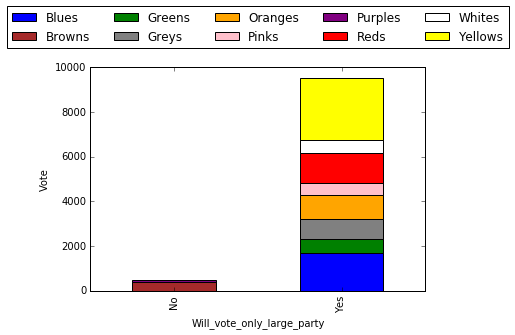

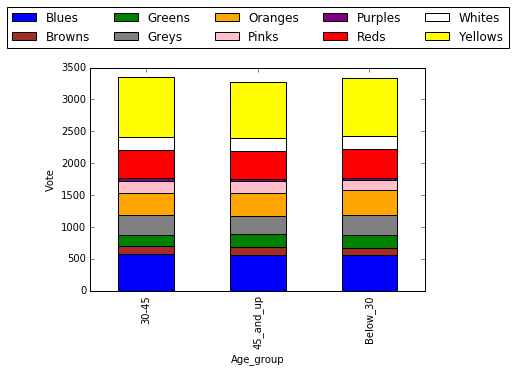

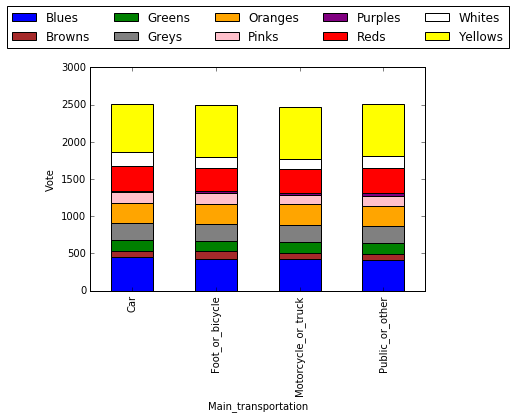

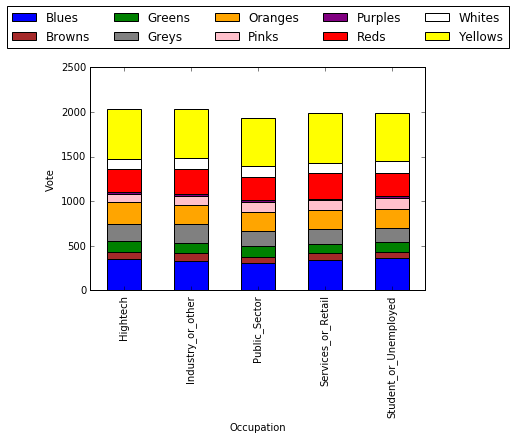

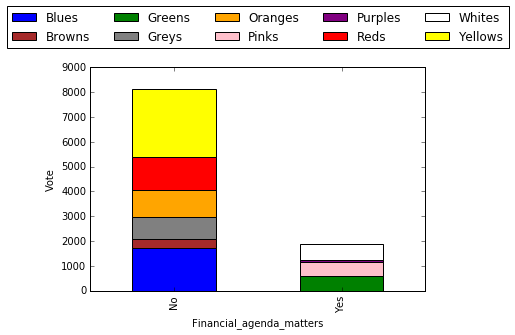

In [9]:
def plot_crosstab(attr1, attr2):
    a1_to_a2 = data[[attr1,attr2]].groupby([attr1, attr2]).size().unstack().fillna(0)
    colors = [col[:-1] for col in a1_to_a2.columns.values] if attr2 == 'Vote' else None
    ax = a1_to_a2.plot(kind='bar', stacked=True, color=colors)
    ax.set_xlabel(attr1)
    ax.set_ylabel(attr2)
    ax.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5,1.3))

def plot_attr_to_vote(attr):
    plot_crosstab(attr, 'Vote')


for attr, cnt in obj_attr:
    if attr=='Vote':
        continue
    plot_attr_to_vote(attr)
    
plt.show()

We can clearly see that given the Vote, we can with almost certainty guess the values of the following attrbiutes:
* Looking_at_poles_results
* Will_vote_only_large_party
* Financial_agenda_matters

Another abnormal observation is made on 'Most_Important_Issue',
We see these relationships:

If someone votes to one of these __Parties__ we can see these are the most important issues for them are:
* Greens --> (Foreign_Affairs OR Other)
* Pinks  --> (Military OR Other)
* Whites --> (Foreign_Affairs OR Military)

If someone's most important __Issues__ are one of these, then we can see that they've voted to one of these parties:
* Foreign_Affairs --> (Greens OR Whites)
* Military       --> (Pinks OR Whites)
* Other        --> (Greens OR Pinks)

there's a potential multi-attribute dependency here, we will try to find it later on


Let's fill in the missing values in the 3 above attributes based on these relations:

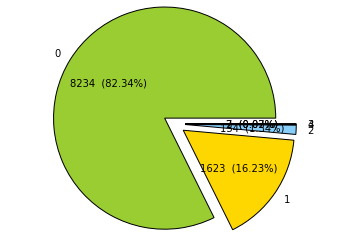

In [10]:
vote_to_cats = data[['Vote','Looking_at_poles_results','Will_vote_only_large_party','Financial_agenda_matters']].dropna().drop_duplicates().set_index(['Vote']).to_dict('index')
vote_to_cats
for party, cat_dict in vote_to_cats.iteritems():
    data[data.Vote==party] = data[data.Vote==party].fillna(cat_dict)

plot_pie_nan_per_row()

Plot every category-category relation:

In [11]:
#for c1,c2 in combinations(obj_attr_names,2):
#    if c1=='Vote' or c2=='Vote':
#        continue
#    plot_crosstab(c1, c2)
    
#plt.show()

We could not infer anything useful from it, and have therefore left the code commented out.

## Pearson's correlation coefficient

We will find the coefficient of the linear correlation between every pair of attributes. The pairs with the highest correlation coefficient will be used to impute each other.

In [12]:
pearson = data.corr(method='pearson')

In [13]:
def get_most_correlated(corr_mat, col, thresh):
    res = pearson[col].reindex(pearson[col].abs().sort_values(ascending=False).index)
    res = res[res.index != col]
    return res[res >= thresh]


pearson_coeff_thresh = 0.95

# a dict mapping each col with its 3 most-correlated cols, only if the corr with the best of them is >=0.9 (in abs value)
sorted_pearson_per_col = {col: \
                          get_most_correlated(pearson, col, pearson_coeff_thresh) for col in pearson\
                         if get_most_correlated(pearson, col, pearson_coeff_thresh).any()}

# for example, here are the columns that are most correlated wth 'Avg_monthly_expense_when_under_age_21'
sorted_pearson_per_col['Avg_monthly_expense_when_under_age_21']

Avg_Residancy_Altitude    1.0
Name: Avg_monthly_expense_when_under_age_21, dtype: float64

Look at that! we have a PERFECT correlation between Avg_Residancy_Altitude and Avg_monthly_expense_when_under_age_21!

This means that there's an exact linear relationship between the two. let's check it out:

In [14]:
(data['Avg_monthly_expense_when_under_age_21'] / data['Avg_Residancy_Altitude']).head(5)

0    3.0
1    3.0
2    3.0
3    3.0
4    3.0
dtype: float64

as we can see, Avg_monthly_expense_when_under_age_21 = 3 * Avg_Residancy_Altitude for every row that contains them both,
i.e. every row that is missing only one of them, can be completed precisely.

This method seems valueable, we shall continue with it for other attributes, who have very high linear correlation with each other.

What we'll do is for each row, for each NaN value in one of those attributes, if there's data in one of its highly-correlated attributes, take this data, multiplied by the mean ratio.

In [15]:
# commented-out on purpose - just shows us the content of the dict for sanity check
#for col in sorted_pearson_per_col:
#    print sorted_pearson_per_col[col],"\n\n"

In [16]:
for col, top_corr_cols in sorted_pearson_per_col.iteritems():
    for corr_col in top_corr_cols.index:
        ratio = (data_copy[col] / data_copy[corr_col]).mean()
        cols = data_copy[[col, corr_col]]
        cols[corr_col] = cols[corr_col].map(lambda x: x*ratio)
        data[col].fillna(cols[corr_col], inplace=True)

data

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Most_Important_Issue,Avg_Residancy_Altitude,Looking_at_poles_results,Yearly_ExpensesK,Married,Gender,Voting_Time,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,Avg_Satisfaction_with_previous_vote,Avg_monthly_income_all_years,%Time_invested_in_work,Yearly_IncomeK,Avg_monthly_expense_on_pets_or_plants,Avg_monthly_household_cost,Will_vote_only_large_party,Phone_minutes_10_years,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Garden_sqr_meter_per_person_in_residancy_area,Last_school_grades,Age_group,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Overall_happiness_score,Num_of_kids_born_last_10_years,Financial_agenda_matters
0,Yellows,9.0,901.074249,174664.625237,Education,300.358083,No,581.521308,No,Male,After_16:00,0.920727,0.100484,4.365483,2.161798,5.962218,6.106218,9204.0,53.981652,622.909384,7061.031848,80356.465721,Yes,338167.031649,24.958153,7.775210e+05,43.518864,90525.336049,100.0,45_and_up,1.0,1067.419550,14.0,Motorcycle_or_truck,Industry_or_other,897.297947,0.0,No
1,Reds,4.0,172.175470,23146.728293,Education,57.391823,No,403.310559,Yes,Female,By_16:00,0.502451,0.540302,3.046957,6.447056,1.486424,6.706155,6238.0,63.899160,710.857600,5454.820791,83550.459496,Yes,162659.407111,26.661913,1.011912e+06,45.259922,3361.213190,100.0,30-45,0.0,1111.093591,10.0,Public_or_other,Industry_or_other,861.981391,0.0,No
2,Whites,3.0,408.262789,97198.945759,Foreign_Affairs,136.087596,No,714.238096,No,Male,By_16:00,0.899025,0.053332,4.178738,1.761754,3.059453,9.383902,3912.0,29.626594,865.494572,8873.370105,100227.594707,Yes,510136.057819,29.419289,1.499705e+06,25.612407,18665.921495,40.0,30-45,1.0,1260.064170,20.0,Public_or_other,Public_Sector,819.390492,1.0,Yes
3,Blues,4.0,401.755874,52952.486970,Financial,133.918625,No,395.407936,Yes,Male,By_16:00,0.778608,0.845698,3.218688,4.677225,3.427241,0.746178,4040.0,48.221850,562.297360,5078.674075,65151.482447,Yes,156347.435485,23.712810,6.333466e+05,39.306687,18078.116698,60.0,30-45,3.0,837.907521,5.0,Car,Industry_or_other,584.598207,1.0,No
4,Blues,5.0,210.935361,29798.270086,Healthcare,70.311787,No,423.801917,Yes,Female,By_16:00,0.278861,0.654061,3.454708,0.886536,1.984614,1.858172,9276.0,78.740853,577.028056,5392.075284,67056.617613,Yes,179608.065018,24.021408,6.669518e+05,17.378412,5024.059163,80.0,30-45,2.0,859.308498,4.0,Motorcycle_or_truck,Services_or_Retail,595.206111,1.0,No
5,Yellows,1.0,245.727791,34939.741843,Financial,81.909264,No,426.566426,Yes,Female,After_16:00,0.956243,0.698686,0.175241,6.287463,3.886282,8.237665,4742.0,37.631324,520.626097,5306.916451,61232.104508,Yes,181958.915515,22.817232,5.430757e+05,3.325105,6801.036742,60.0,Below_30,3.0,779.272032,1.0,Car,Hightech,536.103805,0.0,No
6,Oranges,3.0,176.199132,20881.681123,Education,58.733044,No,355.535483,Yes,Male,By_16:00,0.216134,0.425945,9.580903,6.754966,6.262171,1.593651,9754.0,16.757709,531.117152,4617.589132,65271.724476,Yes,126405.479608,23.045979,5.652641e+05,64.067057,3518.303489,100.0,45_and_up,1.0,877.433966,18.0,Public_or_other,Services_or_Retail,727.749963,0.0,No
7,Greys,4.0,658.354759,148173.767645,Financial,219.451586,No,675.200258,No,Female,By_16:00,0.975477,0.066626,0.334810,4.534706,5.815745,0.664623,5166.0,50.794958,614.771717,7981.546012,75803.304283,Yes,455895.388013,24.794590,7.572321e+05,32.645866,48388.450329,60.0,Below_30,0.0,950.013756,10.0,Foot_or_bicycle,Industry_or_other,658.398370,5.0,No
8,Browns,8.0,1207.000512,152141.832727,Financial,402.333504,Yes,378.148554,Yes,Male,After_16:00,0.789854,0.037650,3.168378,9.579997,2.597317,9.785732,7634.0,55.871403,790.938181,5363.361902,89437.082515,No,142996.328866,28.123623,1.252413e+06,94.871960,162284.581896,60.0,Below_30,5.0,1178.648405,15.0,Motorcycle_or_truck,Industry_or_

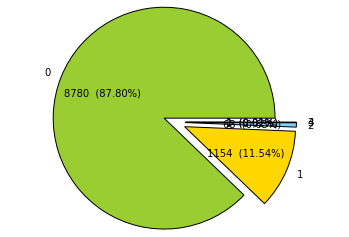

In [17]:
plot_pie_nan_per_row()

we now have ~550 more complete rows!
and about ~110 rows which had more than a signle missing value now have one or less.
only by using columns that have a pearson's correlation coefficient above 0.95 (in abs value), meaning this is a pretty close approximation.

## Spearman's rank

Again we will find the correlation between every pair of attributes. The pairs with the highest correlation coefficient will be used to impute each other.

A high Spearman Rank between X and Y, means that if for two given samples s1 and s2, if x1 > x2 we shold expect y1 > y2.
This implies that the preferred method of imputation based on this rank, is by interpolating Y as a function of X (and vice-versa).

In [18]:
spearman = data.corr(method='spearman')

In [19]:
spearman_coeff_thresh = 0.95

# a dict mapping each col with its 3 most-correlated cols, only if the corr with the best of them is >=0.9 (in abs value)
sorted_spearman_per_col = {col: \
                          get_most_correlated(pearson, col, pearson_coeff_thresh) for col in pearson\
                         if get_most_correlated(pearson, col, pearson_coeff_thresh).any()}

In [20]:
#looking at the dict just for sanity check - commented out
sorted_spearman_per_col

{'Avg_Residancy_Altitude': Avg_monthly_expense_when_under_age_21    1.0
 Name: Avg_Residancy_Altitude, dtype: float64,
 'Avg_monthly_expense_on_pets_or_plants': Yearly_ExpensesK          0.990462
 Phone_minutes_10_years    0.967426
 Name: Avg_monthly_expense_on_pets_or_plants, dtype: float64,
 'Avg_monthly_expense_when_under_age_21': Avg_Residancy_Altitude    1.0
 Name: Avg_monthly_expense_when_under_age_21, dtype: float64,
 'Avg_monthly_household_cost': Political_interest_Total_Score    0.980205
 Yearly_IncomeK                    0.953424
 Name: Avg_monthly_household_cost, dtype: float64,
 'Avg_size_per_room': Yearly_IncomeK    0.977793
 Name: Avg_size_per_room, dtype: float64,
 'Phone_minutes_10_years': Yearly_ExpensesK                         0.974222
 Avg_monthly_expense_on_pets_or_plants    0.967426
 Name: Phone_minutes_10_years, dtype: float64,
 'Political_interest_Total_Score': Avg_monthly_household_cost    0.980205
 Name: Political_interest_Total_Score, dtype: float64,
 'Weight

In [21]:
from scipy import interpolate

## we copy our data so when we impute, we only use original data and not newly imputed data.
## this prevents propagation of approximation errors.
data_copy = data.copy()

for col, top_corr_cols in sorted_pearson_per_col.iteritems():
    for corr_col in top_corr_cols.index:
        print col, "<==>", corr_col
        cols = data_copy[[col, corr_col]].sort_values(by=corr_col)
        print "after sort"
        x_valid = np.isfinite(cols[corr_col])
        y_valid = np.isfinite(cols[col])
        both_valid = x_valid & y_valid
        y_missing_x_valid = x_valid & ~y_valid
        func = interpolate.interp1d(cols[corr_col][both_valid], cols[col][both_valid])
        print "after fit"
        data[col][y_missing_x_valid] = func(cols[corr_col][y_missing_x_valid])
        print "after predict"
        print "\n"

data

Political_interest_Total_Score <==> Avg_monthly_household_cost
after sort
after fit
after predict


Yearly_ExpensesK <==> Avg_monthly_expense_on_pets_or_plants
after sort
after fit
after predict


Yearly_ExpensesK <==> Phone_minutes_10_years
after sort
after fit
after predict


Avg_monthly_household_cost <==> Political_interest_Total_Score
after sort
after fit
after predict


Avg_monthly_household_cost <==> Yearly_IncomeK
after sort
after fit
after predict


Avg_Residancy_Altitude <==> Avg_monthly_expense_when_under_age_21
after sort
after fit
after predict


Yearly_IncomeK <==> Avg_size_per_room
after sort
after fit
after predict


Yearly_IncomeK <==> Weighted_education_rank
after sort
after fit
after predict


Yearly_IncomeK <==> Avg_monthly_household_cost
after sort
after fit
after predict


Weighted_education_rank <==> Yearly_IncomeK
after sort
after fit
after predict


Avg_size_per_room <==> Yearly_IncomeK
after sort
after fit
after predict


Avg_monthly_expense_when_under_age_21 

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Most_Important_Issue,Avg_Residancy_Altitude,Looking_at_poles_results,Yearly_ExpensesK,Married,Gender,Voting_Time,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,Avg_Satisfaction_with_previous_vote,Avg_monthly_income_all_years,%Time_invested_in_work,Yearly_IncomeK,Avg_monthly_expense_on_pets_or_plants,Avg_monthly_household_cost,Will_vote_only_large_party,Phone_minutes_10_years,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Garden_sqr_meter_per_person_in_residancy_area,Last_school_grades,Age_group,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Overall_happiness_score,Num_of_kids_born_last_10_years,Financial_agenda_matters
0,Yellows,9.0,901.074249,174664.625237,Education,300.358083,No,581.521308,No,Male,After_16:00,0.920727,0.100484,4.365483,2.161798,5.962218,6.106218,9204.0,53.981652,622.909384,7061.031848,80356.465721,Yes,338167.031649,24.958153,7.775210e+05,43.518864,90525.336049,100.0,45_and_up,1.0,1067.419550,14.0,Motorcycle_or_truck,Industry_or_other,897.297947,0.0,No
1,Reds,4.0,172.175470,23146.728293,Education,57.391823,No,403.310559,Yes,Female,By_16:00,0.502451,0.540302,3.046957,6.447056,1.486424,6.706155,6238.0,63.899160,710.857600,5454.820791,83550.459496,Yes,162659.407111,26.661913,1.011912e+06,45.259922,3361.213190,100.0,30-45,0.0,1111.093591,10.0,Public_or_other,Industry_or_other,861.981391,0.0,No
2,Whites,3.0,408.262789,97198.945759,Foreign_Affairs,136.087596,No,714.238096,No,Male,By_16:00,0.899025,0.053332,4.178738,1.761754,3.059453,9.383902,3912.0,29.626594,865.494572,8873.370105,100227.594707,Yes,510136.057819,29.419289,1.499705e+06,25.612407,18665.921495,40.0,30-45,1.0,1260.064170,20.0,Public_or_other,Public_Sector,819.390492,1.0,Yes
3,Blues,4.0,401.755874,52952.486970,Financial,133.918625,No,395.407936,Yes,Male,By_16:00,0.778608,0.845698,3.218688,4.677225,3.427241,0.746178,4040.0,48.221850,562.297360,5078.674075,65151.482447,Yes,156347.435485,23.712810,6.333466e+05,39.306687,18078.116698,60.0,30-45,3.0,837.907521,5.0,Car,Industry_or_other,584.598207,1.0,No
4,Blues,5.0,210.935361,29798.270086,Healthcare,70.311787,No,423.801917,Yes,Female,By_16:00,0.278861,0.654061,3.454708,0.886536,1.984614,1.858172,9276.0,78.740853,577.028056,5392.075284,67056.617613,Yes,179608.065018,24.021408,6.669518e+05,17.378412,5024.059163,80.0,30-45,2.0,859.308498,4.0,Motorcycle_or_truck,Services_or_Retail,595.206111,1.0,No
5,Yellows,1.0,245.727791,34939.741843,Financial,81.909264,No,426.566426,Yes,Female,After_16:00,0.956243,0.698686,0.175241,6.287463,3.886282,8.237665,4742.0,37.631324,520.626097,5306.916451,61232.104508,Yes,181958.915515,22.817232,5.430757e+05,3.325105,6801.036742,60.0,Below_30,3.0,779.272032,1.0,Car,Hightech,536.103805,0.0,No
6,Oranges,3.0,176.199132,20881.681123,Education,58.733044,No,355.535483,Yes,Male,By_16:00,0.216134,0.425945,9.580903,6.754966,6.262171,1.593651,9754.0,16.757709,531.117152,4617.589132,65271.724476,Yes,126405.479608,23.045979,5.652641e+05,64.067057,3518.303489,100.0,45_and_up,1.0,877.433966,18.0,Public_or_other,Services_or_Retail,727.749963,0.0,No
7,Greys,4.0,658.354759,148173.767645,Financial,219.451586,No,675.200258,No,Female,By_16:00,0.975477,0.066626,0.334810,4.534706,5.815745,0.664623,5166.0,50.794958,614.771717,7981.546012,75803.304283,Yes,455895.388013,24.794590,7.572321e+05,32.645866,48388.450329,60.0,Below_30,0.0,950.013756,10.0,Foot_or_bicycle,Industry_or_other,658.398370,5.0,No
8,Browns,8.0,1207.000512,152141.832727,Financial,402.333504,Yes,378.148554,Yes,Male,After_16:00,0.789854,0.037650,3.168378,9.579997,2.597317,9.785732,7634.0,55.871403,790.938181,5363.361902,89437.082515,No,142996.328866,28.123623,1.252413e+06,94.871960,162284.581896,60.0,Below_30,5.0,1178.648405,15.0,Motorcycle_or_truck,Industry_or_

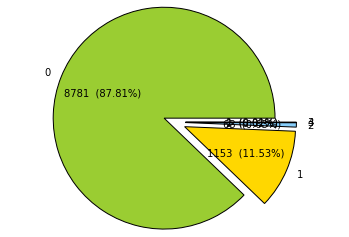

In [22]:
plot_pie_nan_per_row()

# The Complete Completion

We now tried to find a method to properly impute all other missing data, while taking into account mostly the preservation of 
relations between features, to best fit our mission of applying machine-learning on the data.

we considered EM as taught in the lectures, but found the assumption of Multivariate-Gaussian distribution to mostly incorrect when it comes to our data.

after looking for a while, and considering different methods, we have decided to use SoftImpute, based on this paper: http://web.stanford.edu/~hastie/Papers/mazumder10a.pdf.

"SoftImpute" also conviniently has an open-source implementation in Python.

[SoftImpute] Max Singular Value of X_init = 94398743.896831
[SoftImpute] Iter 1: observed MAE=2515.120943 rank=4
[SoftImpute] Iter 2: observed MAE=2520.313588 rank=4
[SoftImpute] Iter 3: observed MAE=2522.238903 rank=4
[SoftImpute] Iter 4: observed MAE=2522.914346 rank=4
[SoftImpute] Iter 5: observed MAE=2523.148567 rank=4
[SoftImpute] Iter 6: observed MAE=2523.234344 rank=4
[SoftImpute] Iter 7: observed MAE=2523.269398 rank=4
[SoftImpute] Iter 8: observed MAE=2523.285448 rank=4
[SoftImpute] Iter 9: observed MAE=2523.293136 rank=4
[SoftImpute] Iter 10: observed MAE=2523.297383 rank=4
[SoftImpute] Iter 11: observed MAE=2523.299549 rank=4
[SoftImpute] Stopped after iteration 11 for lambda=1887974.877937


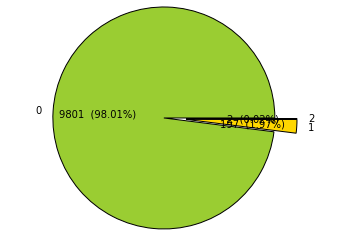

In [23]:
from fancyimpute import SoftImpute

data_no_cat = data.drop(obj_attr_names, axis=1)

completed = SoftImpute().complete(data_no_cat)

data[data_no_cat.columns] = completed

plot_pie_nan_per_row()

We still have to deal with categorical attributes,
we will naively impute them with a class-restricted most-common approach:

In [24]:
from sklearn.preprocessing import Imputer

news = []

for vote in data.Vote.unique():
    vote_restricted = data[data.Vote == vote]
    for c in obj_attr_names:
        if c == 'Vote':
            continue
        print vote,"+",c,":",
        most_common = pd.get_dummies(vote_restricted[c]).sum().sort_values(ascending=False).index[0]
        print most_common
        vote_restricted[c].fillna(most_common, inplace=True)
    news.append(vote_restricted)

data = pd.concat(news)

Yellows + Most_Important_Issue : Healthcare
Yellows + Looking_at_poles_results : No
Yellows + Married : Yes
Yellows + Gender : Female
Yellows + Voting_Time : By_16:00
Yellows + Will_vote_only_large_party : Yes
Yellows + Age_group : 30-45
Yellows + Main_transportation : Public_or_other
Yellows + Occupation : Services_or_Retail
Yellows + Financial_agenda_matters : No
Reds + Most_Important_Issue : Financial
Reds + Looking_at_poles_results : No
Reds + Married : No
Reds + Gender : Male
Reds + Voting_Time : By_16:00
Reds + Will_vote_only_large_party : Yes
Reds + Age_group : Below_30
Reds + Main_transportation : Public_or_other
Reds + Occupation : Services_or_Retail
Reds + Financial_agenda_matters : No
Whites + Most_Important_Issue : Military
Whites + Looking_at_poles_results : No
Whites + Married : No
Whites + Gender : Male
Whites + Voting_Time : By_16:00
Whites + Will_vote_only_large_party : Yes
Whites + Age_group : Below_30
Whites + Main_transportation : Car
Whites + Occupation : Student_o

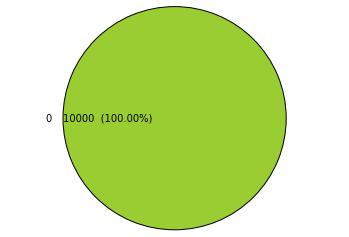

In [25]:
plot_pie_nan_per_row()

In [26]:
data = data.sort_index()

# Type/Value modification

Now we want to re-assign values to categorical and binary attributes:

The categorical, non-binary features will be split into one-hot vectors.
The "binary" ones will be assigned 0 and 1.

__BUT:__ notice Age_group has somewhat "ordinal" values, ['Below_30', '30-45', '45_and_up'], so we would like to map these to integers with the correct ordering.

In [27]:
data['Gender_Int'] = data['Gender'].map({'Female':0, 'Male':1}).astype(float)
data['Voting_Time_Int'] = data['Voting_Time'].map({'By_16:00':0, 'After_16:00':1}).astype(float)

data = data.drop(['Gender','Voting_Time'],axis=1)

for attr in ['Married','Looking_at_poles_results','Financial_agenda_matters','Will_vote_only_large_party']:
    data[attr+'_Int'] = data[attr].map({'No':0, 'Yes':1}).astype(float)
    data = data.drop([attr],axis=1)

# Handle categorical columns and add one-hot vectors
for attr in ['Most_Important_Issue','Main_transportation','Occupation']:
    data = pd.concat([data, pd.get_dummies(data[attr],prefix=attr)], axis=1)
    data = data.drop([attr],axis=1)

# For convenience, we want 'Vote_Int' to be at the beginning, but we're not dropping 'Vote' just yet
data = pd.concat([pd.get_dummies(data['Vote'],prefix='Vote'),data], axis=1)

#for attr,cnt in obj_attr:
#    if attr=='Vote':
#        data[attr] = data[attr].astype('category').cat.rename_categories(range(1,cnt+1)).astype('float')

data['Age_group_Int'] = data['Age_group'].map({'Below_30':0, '30-45':1, '45_and_up':2}).astype(float)
data = data.drop(['Age_group'],axis=1)


In [28]:
data.head(10)

,Vote_Blues,Vote_Browns,Vote_Greens,Vote_Greys,Vote_Oranges,Vote_Pinks,Vote_Purples,Vote_Reds,Vote_Whites,Vote_Yellows,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Residancy_Altitude,Yearly_ExpensesK,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,Avg_Satisfaction_with_previous_vote,Avg_monthly_income_all_years,%Time_invested_in_work,Yearly_IncomeK,Avg_monthly_expense_on_pets_or_plants,Avg_monthly_household_cost,Phone_minutes_10_years,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Garden_sqr_meter_per_person_in_residancy_area,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years,Gender_Int,Voting_Time_Int,Married_Int,Looking_at_poles_results_Int,Financial_agenda_matters_Int,Will_vote_only_large_party_Int,Most_Important_Issue_Education,Most_Important_Issue_Environment,Most_Important_Issue_Financial,Most_Important_Issue_Foreign_Affairs,Most_Important_Issue_Healthcare,Most_Important_Issue_Military,Most_Important_Issue_Other,Most_Important_Issue_Social,Main_transportation_Car,Main_transportation_Foot_or_bicycle,Main_transportation_Motorcycle_or_truck,Main_transportation_Public_or_other,Occupation_Hightech,Occupation_Industry_or_other,Occupation_Public_Sector,Occupation_Services_or_Retail,Occupation_Student_or_Unemployed,Age_group_Int
0,0,0,0,0,0,0,0,0,0,1,Yellows,9.0,901.074249,174664.625237,300.358083,581.521308,0.920727,0.100484,4.365483,2.161798,5.962218,6.106218,9204.0,53.981652,622.909384,7061.031848,80356.465721,338167.031649,24.958153,7.775210e+05,43.518864,90525.336049,100.0,1.0,1067.419550,14.0,897.297947,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2.0
1,0,0,0,0,0,0,0,1,0,0,Reds,4.0,172.175470,23146.728293,57.391823,403.310559,0.502451,0.540302,3.046957,6.447056,1.486424,6.706155,6238.0,63.899160,710.857600,5454.820791,83550.459496,162659.407111,26.661913,1.011912e+06,45.259922,3361.213190,100.0,0.0,1111.093591,10.0,861.981391,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1.0
2,0,0,0,0,0,0,0,0,1,0,Whites,3.0,408.262789,97198.945759,136.087596,714.238096,0.899025,0.053332,4.178738,1.761754,3.059453,9.383902,3912.0,29.626594,865.494572,8873.370105,100227.594707,510136.057819,29.419289,1.499705e+06,25.612407,18665.921495,40.0,1.0,1260.064170,20.0,819.390492,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1.0
3,1,0,0,0,0,0,0,0,0,0,Blues,4.0,401.755874,52952.486970,133.918625,395.407936,0.778608,0.845698,3.218688,4.677225,3.427241,0.746178,4040.0,48.221850,562.297360,5078.674075,65151.482447,156347.435485,23.712810,6.333466e+05,39.306687,18078.116698,60.0,3.0,837.907521,5.0,584.598207,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1.0
4,1,0,0,0,0,0,0,0,0,0,Blues,5.0,210.935361,29798.270086,70.311787,423.801917,0.278861,0.654061,3.454708,0.886536,1.984614,1.858172,9276.0,78.740853,577.028056,5392.075284,67056.617613,179608.065018,24.021408,6.669518e+05,17.378412,5024.059163,80.0,2.0,859.308498,4.0,595.206111,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1.0
5,0,0,0,0,0,0,0,0,0,1,Yellows,1.0,245.727791,34939.741843,81.909264,426.566426,0.956243,0.698686,0.175241,6.287463,3.886282,8.237665,4742.0,37.631324,520.626097,5306.916451,61232.104508,181958.915515,22.817232,5.430757e+05,3.325105,6801.036742,60.0,3.0,779.272032,1.0,536.103805,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.0
6,0,0,0,0,1,0,0,0,0,0,Oranges,3.0,176.199132,20881.681123,58.733044,355.535483,0.216134,0.425945,9.580903,6.754966,6.262171,1.593651,9754.0,16.757709,531.117152,4617.589132,65271.724476,126405.479608,23.045979,5.652641e+05,64.067057,3518.303489,100.0,1.0,877.433966,18.0,727.749963,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2.0
7,0,0,0,1,0,0,0,0,0,0,Greys,4.0,658.3547

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 62 columns):
Vote_Blues                                       10000 non-null uint8
Vote_Browns                                      10000 non-null uint8
Vote_Greens                                      10000 non-null uint8
Vote_Greys                                       10000 non-null uint8
Vote_Oranges                                     10000 non-null uint8
Vote_Pinks                                       10000 non-null uint8
Vote_Purples                                     10000 non-null uint8
Vote_Reds                                        10000 non-null uint8
Vote_Whites                                      10000 non-null uint8
Vote_Yellows                                     10000 non-null uint8
Vote                                             10000 non-null category
Occupation_Satisfaction                          10000 non-null float64
Avg_monthly_expense_when_under_age_21          

# Outlier Detection

We will use Isolation Forests for this task.
We've decided to go with Isolation Forests as they are based on Random Forests and therefore deal well with multidimensional data, like in our case.

In [30]:
from sklearn.ensemble import IsolationForest

df = data.drop(['Vote'],axis=1)
outliers_fraction = 0.05

clf = IsolationForest(n_estimators=300, max_samples=0.5, contamination=outliers_fraction, n_jobs=-1)

clf.fit(df)
y_pred = clf.predict(df)
outliers = np.where(y_pred==-1)[0]

In [31]:
outliers

array([   8,   25,   40,   41,   51,   53,   63,   84,   93,  100,  113,
        114,  119,  151,  173,  195,  223,  226,  246,  256,  301,  315,
        377,  378,  390,  493,  494,  507,  509,  511,  554,  558,  564,
        569,  571,  578,  585,  590,  614,  621,  626,  636,  676,  681,
        685,  714,  719,  730,  753,  770,  795,  829,  839,  844,  847,
        859,  865,  894,  917,  924,  930,  943,  965,  984,  999, 1010,
       1015, 1048, 1050, 1074, 1085, 1120, 1145, 1178, 1182, 1211, 1214,
       1245, 1288, 1300, 1317, 1323, 1348, 1390, 1412, 1435, 1451, 1458,
       1467, 1523, 1550, 1598, 1601, 1616, 1636, 1646, 1670, 1686, 1697,
       1713, 1727, 1746, 1750, 1771, 1820, 1832, 1834, 1892, 1896, 1945,
       1978, 1992, 2007, 2033, 2069, 2136, 2196, 2218, 2228, 2246, 2247,
       2254, 2263, 2269, 2281, 2311, 2314, 2320, 2344, 2424, 2435, 2443,
       2487, 2570, 2584, 2592, 2596, 2630, 2647, 2688, 2708, 2744, 2758,
       2786, 2825, 2853, 2860, 2867, 2873, 2895, 29

## Test Classification before/after removing the outliers

In [32]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

vote_list = [v for v in data.columns.values if 'Vote' in v and v != 'Vote']
df = data.drop(vote_list,axis=1)
for attr,cnt in obj_attr:
    if attr == 'Vote':
        df[attr] = df[attr].astype('category').cat.rename_categories(range(1,cnt+1)).astype('float')


In [33]:
df

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Residancy_Altitude,Yearly_ExpensesK,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,Avg_Satisfaction_with_previous_vote,Avg_monthly_income_all_years,%Time_invested_in_work,Yearly_IncomeK,Avg_monthly_expense_on_pets_or_plants,Avg_monthly_household_cost,Phone_minutes_10_years,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Garden_sqr_meter_per_person_in_residancy_area,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years,Gender_Int,Voting_Time_Int,Married_Int,Looking_at_poles_results_Int,Financial_agenda_matters_Int,Will_vote_only_large_party_Int,Most_Important_Issue_Education,Most_Important_Issue_Environment,Most_Important_Issue_Financial,Most_Important_Issue_Foreign_Affairs,Most_Important_Issue_Healthcare,Most_Important_Issue_Military,Most_Important_Issue_Other,Most_Important_Issue_Social,Main_transportation_Car,Main_transportation_Foot_or_bicycle,Main_transportation_Motorcycle_or_truck,Main_transportation_Public_or_other,Occupation_Hightech,Occupation_Industry_or_other,Occupation_Public_Sector,Occupation_Services_or_Retail,Occupation_Student_or_Unemployed,Age_group_Int
0,10.0,9.0,901.074249,174664.625237,300.358083,581.521308,0.920727,0.100484,4.365483,2.161798,5.962218,6.106218,9204.0,53.981652,622.909384,7061.031848,80356.465721,338167.031649,24.958153,7.775210e+05,43.518864,90525.336049,100.0,1.000000,1067.419550,14.0,897.297947,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2.0
1,8.0,4.0,172.175470,23146.728293,57.391823,403.310559,0.502451,0.540302,3.046957,6.447056,1.486424,6.706155,6238.0,63.899160,710.857600,5454.820791,83550.459496,162659.407111,26.661913,1.011912e+06,45.259922,3361.213190,100.0,0.000000,1111.093591,10.0,861.981391,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1.0
2,9.0,3.0,408.262789,97198.945759,136.087596,714.238096,0.899025,0.053332,4.178738,1.761754,3.059453,9.383902,3912.0,29.626594,865.494572,8873.370105,100227.594707,510136.057819,29.419289,1.499705e+06,25.612407,18665.921495,40.0,1.000000,1260.064170,20.0,819.390492,1.000000,1.0,0.0,0.0,0.0,1.0,1.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1.0
3,1.0,4.0,401.755874,52952.486970,133.918625,395.407936,0.778608,0.845698,3.218688,4.677225,3.427241,0.746178,4040.0,48.221850,562.297360,5078.674075,65151.482447,156347.435485,23.712810,6.333466e+05,39.306687,18078.116698,60.0,3.000000,837.907521,5.0,584.598207,1.000000,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1.0
4,1.0,5.0,210.935361,29798.270086,70.311787,423.801917,0.278861,0.654061,3.454708,0.886536,1.984614,1.858172,9276.0,78.740853,577.028056,5392.075284,67056.617613,179608.065018,24.021408,6.669518e+05,17.378412,5024.059163,80.0,2.000000,859.308498,4.0,595.206111,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1.0
5,10.0,1.0,245.727791,34939.741843,81.909264,426.566426,0.956243,0.698686,0.175241,6.287463,3.886282,8.237665,4742.0,37.631324,520.626097,5306.916451,61232.104508,181958.915515,22.817232,5.430757e+05,3.325105,6801.036742,60.0,3.000000,779.272032,1.0,536.103805,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.0
6,5.0,3.0,176.199132,20881.681123,58.733044,355.535483,0.216134,0.425945,9.580903,6.754966,6.262171,1.593651,9754.0,16.757709,531.117152,4617.589132,65271.724476,126405.479608,23.045979,5.652641e+05,64.067057,3518.303489,100.0,1.000000,877.433966,18.0,727.749963,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2.0
7,4.0,4.0,658.354759,148173.767645,219.451586,675.200258,0.975477,0.066626,0.334810,4.534706,5.815745,0.664623,5166.0,50.794958,614.771717,7981.546012,75803.304283,455895.388013,24.794590,7.572321e+05,32.645866,48388.450329,60.0,0.000000,950.0137

In [34]:
avg_tree = 0
#avg_svm = 0
    
train_data_X = df.drop(['Vote'],axis=1).values
train_data_Y = df['Vote'].values

# Prepare train and test data using cross validation
X_train, X_test, Y_train, Y_test = train_test_split(train_data_X,train_data_Y)
   
for i in range(10):
 
    # Example usage 1
    forest = RandomForestClassifier(n_estimators = 10)
    clf = forest.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    avg_tree += metrics.accuracy_score(Y_test, Y_pred)

    #SVM performs badly because we have not selected a feature subset yet
    
    # Example usage 2
    #svm = SVC()
    #clf = svm.fit(X_train, Y_train)
    #Y_pred = clf.predict(X_test)
    #avg_svm += metrics.accuracy_score(Y_test, Y_pred)
    
print avg_tree/10 #, avg_svm/10

0.84884


### After removing...

In [35]:
df_no_outliers = df.drop(data.index[outliers])

df_train_data_X = df_no_outliers.drop(['Vote'], axis=1).values
df_train_data_Y = df_no_outliers.Vote.values


In [36]:
avg_tree = 0
#avg_svm = 0

# Prepare train and test data using cross validation
df_X_train, df_X_test, df_Y_train, df_Y_test = train_test_split(df_train_data_X, df_train_data_Y)

for i in range(10):
    
    # Example usage 1
    forest = RandomForestClassifier(n_estimators = 10)
    clf = forest.fit(df_X_train, df_Y_train)
    df_Y_pred = clf.predict(df_X_test)
    avg_tree += metrics.accuracy_score(df_Y_test, df_Y_pred)

    #SVM performs badly because we have not selected a feature subset yet
    
    # Example usage 2
    #svm = SVC()
    #clf = svm.fit(df_X_train, df_Y_train)
    #df_Y_pred = clf.predict(df_X_test)
    #avg_svm += metrics.accuracy_score(df_Y_test, df_Y_pred)

print avg_tree/10  #, avg_svm/10

0.845557894737


Removing the outliers didn't seem to improve our accuracy, meaning the outliers did not introduce a strong bias in the first place

## Normalization

We want to scale the data to be of more use in certain classifiers, like those based on euclidean/L2 distance, such as KNN.

We will leave one-hot vectors and binary attributes as they are, and scale other attributes to be with a variance of 1 and a mean of 0.

In [37]:
from sklearn.preprocessing import scale

In [38]:
attrs = [attr for attr in data if count_categories(attr) > 2 and attr != 'Vote']

for attr in attrs:
    data[attr] = scale(data[attr])

In [39]:
data

,Vote_Blues,Vote_Browns,Vote_Greens,Vote_Greys,Vote_Oranges,Vote_Pinks,Vote_Purples,Vote_Reds,Vote_Whites,Vote_Yellows,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Residancy_Altitude,Yearly_ExpensesK,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,Avg_Satisfaction_with_previous_vote,Avg_monthly_income_all_years,%Time_invested_in_work,Yearly_IncomeK,Avg_monthly_expense_on_pets_or_plants,Avg_monthly_household_cost,Phone_minutes_10_years,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Garden_sqr_meter_per_person_in_residancy_area,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years,Gender_Int,Voting_Time_Int,Married_Int,Looking_at_poles_results_Int,Financial_agenda_matters_Int,Will_vote_only_large_party_Int,Most_Important_Issue_Education,Most_Important_Issue_Environment,Most_Important_Issue_Financial,Most_Important_Issue_Foreign_Affairs,Most_Important_Issue_Healthcare,Most_Important_Issue_Military,Most_Important_Issue_Other,Most_Important_Issue_Social,Main_transportation_Car,Main_transportation_Foot_or_bicycle,Main_transportation_Motorcycle_or_truck,Main_transportation_Public_or_other,Occupation_Hightech,Occupation_Industry_or_other,Occupation_Public_Sector,Occupation_Services_or_Retail,Occupation_Student_or_Unemployed,Age_group_Int
0,0,0,0,0,0,0,0,0,0,1,Yellows,1.216217,1.397513,1.651216,1.397513,0.435482,1.455261,-1.391711,-0.217866,-0.971404,0.349461,0.389838,1.343946,0.128385,-0.005566,0.400429,0.433805,0.256536,0.056610,-0.119204,-0.225179,1.031208,1.336916,-0.789176,0.652439,0.608066,1.426150,-0.642727,1.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1.237235
1,0,0,0,0,0,0,0,1,0,0,Reds,-0.533826,-0.823715,-0.825551,-0.823715,-0.601835,0.000952,0.144313,-0.674848,0.507304,-1.199434,0.598968,-0.126372,0.473556,0.627478,-0.465774,0.657574,-0.609528,0.587372,0.572280,-0.164716,-0.554756,1.336916,-1.579937,0.900025,-0.084227,1.194533,-0.642727,0.0,0.0,1.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0.008966
2,0,0,0,0,0,0,0,0,1,0,Whites,-0.883835,-0.104269,0.384934,-0.104269,1.207992,1.379805,-1.556382,-0.282590,-1.109447,-0.655071,1.532392,-1.279427,-0.719272,1.740543,1.377794,1.825963,1.105139,1.446360,2.011331,-0.847028,-0.276285,-1.629404,-0.789176,1.744530,1.646505,0.915209,0.284471,1.0,0.0,0.0,0.0,1.0,1.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0.008966
3,1,0,0,0,0,0,0,0,0,0,Blues,-0.533826,-0.124098,-0.338335,-0.124098,-0.647834,0.961128,1.210877,-0.615329,-0.103409,-0.527794,-1.478596,-1.215974,-0.072080,-0.441847,-0.668624,-0.631445,-0.640676,-0.331343,-0.544536,-0.371458,-0.286980,-0.640630,0.792346,-0.648650,-0.949593,-0.624632,0.284471,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.008966
4,1,0,0,0,0,0,0,0,0,0,Blues,-0.183817,-0.705600,-0.716823,-0.705600,-0.482561,-0.776449,0.541604,-0.533528,-1.411456,-1.027030,-1.090971,1.379638,0.990108,-0.335816,-0.499612,-0.497973,-0.525893,-0.235207,-0.445397,-1.132974,-0.524500,0.348143,0.001585,-0.527329,-1.122666,-0.555062,0.284471,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0.008966
5,0,0,0,0,0,0,0,0,0,1,Yellows,-1.583852,-0.599574,-0.632778,-0.599574,-0.466469,1.578749,0.697452,-1.670143,0.452234,-0.368938,1.132830,-0.867976,-0.440674,-0.741793,-0.545536,-0.906034,-0.514293,-0.610337,-0.810847,-1.621012,-0.492168,-0.640630,0.792346,-0.981051,-1.641886,-0.942673,-0.642727,0.0,1.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,-1.219303
6,0,0,0,0,1,0,0,0,0,0,Oranges,-0.883835,-0.811454,-0.862577,-0.811454,-0.879921,-0.994545,-0.255069,1.589722,0.613554,0.453263,-1.183179,1.616594,-1.167162,-0.666279,-0.917279,-0.623021,-0.788428,-0.539077,-0.745388,0.488410,-0.551898,1.336916,-0.789176,-0.424577,1.300359,0.314202,-0.642727,1.0,0.0,1.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,

## DF - what is this DataFrame below?

The following dataframe is the same as the normal "data" DataFrame, except that the one-hot vector for Votes has been removed, and the 'Vote' attribute values have been replaced with numbers. This is because train_test_split does not work with String based attributes.

This DataFrame serves for testing things and selecting the feature subset.

In [40]:
df = data.drop(vote_list,axis=1)
for attr,cnt in obj_attr:
    if attr == 'Vote':
        df[attr] = df[attr].astype('category').cat.rename_categories(range(1,cnt+1)).astype('float')

In [41]:
#import scipy.stats as stats
#for col in [c for c in data if data[c].dtype == np.float64]:
#    ax = data[col].plot(kind='density')
#    ax.set_xlabel(col)
#    plt.show()

# Splitting the dataset

In [42]:
from sklearn.model_selection import train_test_split
data_X = data.drop(vote_list+['Vote'], axis=1)
data_Y = df['Vote']

#Split data after preprocessing

# split first level, having train with 60% of data.
x_train, other_X, y_train, other_Y = train_test_split(data_X,data_Y,train_size=.6, stratify=data_Y, random_state=313341596)

# split scecond level, operating on the remaining 40%, splitting in half.
x_test, x_validation, y_test, y_validation = train_test_split(other_X,other_Y,train_size=.5, stratify=other_Y, random_state=302325709)

# "Merge" the X and Y of each set (will save in a single CSV file)

afterpp_train = data.iloc[x_train.index]
afterpp_test = data.iloc[x_test.index]
afterpp_validation = data.iloc[x_validation.index]

#Split original data based on this split

orig_train = data_copy.iloc[x_train.index]
orig_test = data_copy.iloc[x_test.index]
orig_validation = data_copy.iloc[x_validation.index]




afterpp_train.to_csv('afterpp_train.csv')
afterpp_test.to_csv('afterpp_test.csv')
afterpp_validation.to_csv('afterpp_validation.csv')

orig_train.to_csv('orig_train.csv')
orig_test.to_csv('orig_test.csv')
orig_validation.to_csv('orig_validation.csv')

# Bonuses

TL;DR: We've implemented:

* Hybrid Selection Scheme (see BDS, which isn't the actual BDS algorithm but a variation of it. more explanation there).
* Relief algorithm.
* Role of attributes with respect to classes ('Vote') as seen in the Imputing section.
* SFS implementation.

## Relief Algorithm

This is the implementation of the relief algorithm.

## DISCUSS ADVANTAGES AND DISADVANTAGES OF RELIEF

The clear advantage of the Relief algorithm [family] is that they are able to detect conditional dependencies between attributes. Other algorithms can also do this but mostly indirectly and as a result of other factors. (For example, in SFS, some attributes aren't as useful once other attributes have been added because they may have much in common, but the other feature may be just as useful.). In Relief, we first go over all the features, find the best ones, and then pick those at once.

A clear disadvantage is that Relief takes a long time to run.
We also noticed it produces feature-subsets much larger (2x~) than subsets produced by other methods we have tried, which means larger runtime complexity when fitting and predicting.

## WERE THERE ANY FEATURES ALWAYS / NEVER SELECTED BY IT?

We've noticed that some features are never selected, and others always are.
We couldn't spot any "bias" in the algorithm itself (as we did in SFS - will be explained later), but it does seem to align with the results of other algorithms as to which features are most important.


In [43]:
def find_closest(data,index,row):
    nearhit_dist = nearmiss_dist = None
    nearhit = nearmiss = None

    for idx, cur_row in data.iterrows():
        if idx == index:
            continue
        cur_vote = cur_row.Vote
        dist = sum([(row[c]-cur_row[c])**2 for c in data if c != 'Vote'])
        if cur_vote == row.Vote:
            if nearhit_dist is None or dist < nearhit_dist:
                nearhit_dist = dist
                nearhit = cur_row
        else:
            if nearmiss_dist is None or dist < nearmiss_dist:
                nearmiss_dist = dist
                nearmiss = cur_row
    return nearhit, nearmiss
        

def relief(data, samples=0.2,tau=0):
    weights = {}
    #initialize the weights
    for f in data.columns.values:
        if 'Vote' in f:
            continue
        weights[f] = 0
    #go over the samples
    i = 0
    for index, row in data.sample(frac=samples).iterrows():
        i = i + 1
        print "i =", i
        vote = row.Vote
        #find nearest from class, and its index
        #find nearest from outside class
        nearhit, nearmiss = find_closest(data,index,row)
        for f in data.columns.values:
            if 'Vote' in f:
                continue
            #print f
            #weights[f] = weights[f] + (xi-nearmiss(xi))^2 - (xi-nearhit(xi))^2
            weights[f] = weights[f] + (row[f] - nearmiss[f])**2 - (row[f] - nearhit[f])**2
        attrs = [attr for attr, w in weights.iteritems() if w>tau]
        print "attrs_size:",len(attrs)
    return attrs
    
#attrs = relief(data,samples=0.01)
#attrs

In [44]:
print len(attrs)
open_set = set(attrs)

28


In [45]:
#df

## SFS

Below is the implementation of the SFS Feature Selection Algorithm.


## DISCUSS ADVANTAGES AND DISADVANTAGES OF RELIEF

* SFS is prone to Local Maxima and might not include useful features. This is basically an SAHC algorithm. This could be solved, or at least improved, with Random Restarts, Side Stepping, and Simulated Annealing.
* The first disadvantage we can think of is the fact that SFS is not very conservative. This means that there might be useful features it will not include, because it will reach a local maximum.
* SFS is affected by bias of the wrapped classifier, and somewhat "inherits" its disadvantages. One example would be RandomForest almost always selecting "Last_School_Grades" as its first attribute, because it improves its accuracy the most. A different classifier might get more use out of a different feature and select it instead.
* SFS might miss out on multi-attribute relations due to its nature of starting with an empty subset and greedily expanding it and stops right a the point that another single step doesn't benfit us (even though perhaps two more steps could overcome the local maximum).

## WERE THERE ANY FEATURES ALWAYS / NEVER SELECTED BY IT?

We've noticed that some features are never selected, and others always are.
It mostly occurs on the first step of the algorithm, which always starts at the same position, and chooses the feature that by itself helps gain the most accuracy, and even though it might not be as useful once other features are selected, SFS will not remove it from the subset.

As part of our feature selection we've ran SFS multiple times and counted the number of appearances each attribute appeared in one of the subsets returned by SFS. There we can see which features were almost always selected and which features almost never, or were very rarely selected.


In [46]:
#df

In [47]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

def _sfs(df,learning_model,S=None,cur_max=0):
    if S is None:
        S = set(['Vote'])
    #print S
    max_feature = None
    for col in [c for c in df if c not in S]:
        S.add(col)
        subset = df[list(S)]
        train_data_X = subset.drop(['Vote'], axis=1).values
        train_data_Y = subset.Vote.values
        # Prepare train and test data using cross validation
        X_train, X_test, Y_train, Y_test = train_test_split(train_data_X, train_data_Y)
        clf = learning_model.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        tmp = metrics.accuracy_score(Y_test, Y_pred)
        if(tmp > cur_max):
            cur_max = tmp
            max_feature = col
        S.remove(col)
    if (max_feature is not None):
        S.add(max_feature)
        #print cur_max
        S, cur_max = _sfs(df,learning_model,S,cur_max)
    return S, cur_max


#df: dataframe, d-dimensional feature-set
#learning_model: classifier by which to measure predictive power, higher = better
#iterations: this is to allow restarts because the learning_model may be random. picks the best subset out of all
def sfs(df,learning_model,iterations=1):
    best_score = 0
    best_subset = set()
    #because the function is susceptible to local maximums,
    #we will run it with random restarts and take the best subset
    for i in range(iterations):
        S, score = _sfs(df,learning_model)
        if(score > best_score):
            best_score = score
            best_subset = S
    if 'Vote' in best_subset:
        best_subset.remove('Vote')
    return best_subset, best_score

# Example usage 1
#forest = RandomForestClassifier(n_estimators = 15)
#S, accuracy = sfs(df,forest,5)
#print S, accuracy

# Example usage 2
#svm = SVC()
#S, accuracy = sfs(df,svm)
#print S, accuracy

## Hybrid Feature Selection

This is a variation of the BDS algorithm.
As input, it receives:
* A DataFrame
* A learning model (basically a classifier or something that can judge the quality of the subset)
* Number of iterations, if we want to allow restarts because of non-deterministic learning models
* Subset of features to filter from. If none is specified, start with all features.

The modified BDS Algorithm runs like a regular BDS algorithm but returns the best subset it has seen in either path for the SFS and SBS, and not just the subset where the SFS and SBS meet at.

The rationale is that we'll return the best subset from either SBS and SFS and indirectly, also the best subset BDS would return, all combined into one algorithm.

We've allowed it the feature to begin with a given subset and pick a subset from that, because we will give it the subset found by Relief.

In [49]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

def _bds(df,learning_model,sfs_open=None):
    if open_set is None:
        sfs_open = set(df.columns.values)
        sfs_open.remove('Vote')
    sbs_open = set.copy(sfs_open)
    
    S_sfs = set()
    S_sbs = set.copy(sfs_open)
    
    S_max = None
    
    cur_max_forward = 0
    cur_max_backward = 0
    cur_max = 0
    
    train_data_Y = df.Vote.values
    
    while S_sfs != S_sbs:
        
        max_feature = None
        min_feature = None
        changed = False
        
        print "#### FORWARD ####"
        print S_sfs
        #forward selection
        #find a feature in sfs_open and add it
        for f in sfs_open:
            S_sfs.add(f)
            subset = df[list(S_sfs)]
            
            train_data_X = subset.values
            
            # Prepare train and test data using cross validation
            X_train, X_test, Y_train, Y_test = train_test_split(train_data_X, train_data_Y)
            clf = learning_model.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test)
            tmp = metrics.accuracy_score(Y_test, Y_pred)
            
            #pick the best feature to add
            if max_feature is None:
                max_feature = f
            if tmp > cur_max_forward:
                cur_max_forward = tmp
                max_feature = f
            if tmp > cur_max:
                cur_max = tmp
                S_max = S_sfs
            S_sfs.remove(f)
        if (max_feature is not None):
            S_sfs.add(max_feature)
            #sbs can't remove feature selected by sfs
            sbs_open.remove(max_feature)
            sfs_open.remove(max_feature)
            
        print "#### BACKWARD ####"
        print S_sbs
        #backward selection
        for f in sbs_open:
            S_sbs.remove(f)
            subset = df[list(S_sbs)]
            
            train_data_X = subset.values
            
            # Prepare train and test data using cross validation
            X_train, X_test, Y_train, Y_test = train_test_split(train_data_X, train_data_Y)
            clf = learning_model.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test)
            tmp = metrics.accuracy_score(Y_test, Y_pred)
            
            #find least damaging feature to remove
            if min_feature is None:
                min_feature = f
            if(tmp > cur_max_backward):
                cur_max_backward = tmp
                min_feature = f
            if tmp > cur_max:
                cur_max = tmp
                S_max = S_sfs
            S_sbs.add(f)
        if (min_feature is not None):
            S_sbs.remove(min_feature)
            sfs_open.remove(min_feature)
            sbs_open.remove(min_feature)
    return S_max, cur_max


#df: dataframe
#learning_model: classifier by which to measure predictive power, higher = better
#iterations: this is to allow restarts because the learning_model may be random. picks the best subset out of all
def bds(df,learning_model,iterations=1,open_set=None):
    best_score = 0
    best_subset = None
    #because the function is susceptible to local maximums,
    #we will run it multiple times and pick the best subset
    for i in range(iterations):
        S, score = _bds(df,learning_model,open_set)
        if(score > best_score):
            best_score = score
            best_subset = S
    return best_subset, best_score

# Example usage 1
#forest = RandomForestClassifier(n_estimators = 15)
#S, accuracy = bds(df,forest,iterations=1,open_set=open_set)
#print S, accuracy

# Example usage 2
#svm = SVC()
#S, accuracy = sfs(df,svm)
#print S, accuracy

# Select the feature subset

1. Run SFS Multiple times.
2. Run Relief.
3. Run BDS on the subset of features selected by Relief.
4. Pick the most common features selected by SFS, united with the BDS run.

In [50]:
from collections import Counter

sfs_runs = 20
sfs_feature_threshold = sfs_runs*0.2

relief_threshold = 0.01

SFS_subset = set()

forest = RandomForestClassifier(n_estimators = 15)
sfs_counter = Counter()
for i in range(sfs_runs):
    print "############"
    print i
    S, accuracy = sfs(df,forest)
    print S
    print accuracy
    sfs_counter += Counter(S)
    print sfs_counter

most_common = {f for f,c in sfs_counter.most_common() if c > sfs_feature_threshold}

print "### DONE WITH SFS ###"
print most_common

print "### RELIEF ###"
relief_features = set(relief(data,samples=0.01))
print relief_features
print "### DONE WITH RELIEF ###"

print "### BDS ###"

bds_features, accuracy = bds(df,forest,iterations=1,open_set=relief_features)
print "### DONE WITH BDS ###"
print bds_features
print accuracy

feature_subset = most_common | bds_features

print "FEATURE SUBSET:"
print feature_subset

############
0
set(['Political_interest_Total_Score', 'Yearly_IncomeK', 'Last_school_grades', 'Married_Int', 'Avg_monthly_expense_on_pets_or_plants'])
0.8548
Counter({'Political_interest_Total_Score': 1, 'Yearly_IncomeK': 1, 'Last_school_grades': 1, 'Married_Int': 1, 'Avg_monthly_expense_on_pets_or_plants': 1})
############
1
set(['Overall_happiness_score', 'Looking_at_poles_results_Int', 'Phone_minutes_10_years', 'Political_interest_Total_Score', 'Avg_monthly_household_cost', 'Last_school_grades', 'Most_Important_Issue_Other'])
0.8716
Counter({'Political_interest_Total_Score': 2, 'Last_school_grades': 2, 'Avg_monthly_household_cost': 1, 'Yearly_IncomeK': 1, 'Married_Int': 1, 'Most_Important_Issue_Other': 1, 'Overall_happiness_score': 1, 'Looking_at_poles_results_Int': 1, 'Phone_minutes_10_years': 1, 'Avg_monthly_expense_on_pets_or_plants': 1})
############
2
set(['Overall_happiness_score', 'Last_school_grades', 'Looking_at_poles_results_Int', 'Weighted_education_rank', 'Phone_minutes_

set(['Yearly_ExpensesK', 'Avg_monthly_household_cost', 'Overall_happiness_score', 'Last_school_grades', 'Most_Important_Issue_Foreign_Affairs'])
0.8692
Counter({'Last_school_grades': 12, 'Overall_happiness_score': 11, 'Yearly_ExpensesK': 8, 'Avg_monthly_household_cost': 6, 'Political_interest_Total_Score': 5, 'Yearly_IncomeK': 4, 'Phone_minutes_10_years': 4, 'Avg_size_per_room': 2, 'AVG_lottary_expanses': 2, 'Avg_monthly_income_all_years': 2, 'Garden_sqr_meter_per_person_in_residancy_area': 2, 'Looking_at_poles_results_Int': 2, 'Main_transportation_Car': 2, 'Weighted_education_rank': 2, 'Avg_monthly_expense_on_pets_or_plants': 2, 'Married_Int': 1, 'Voting_Time_Int': 1, 'Avg_monthly_expense_when_under_age_21': 1, 'Occupation_Services_or_Retail': 1, 'Financial_agenda_matters_Int': 1, 'Avg_Satisfaction_with_previous_vote': 1, 'Most_Important_Issue_Other': 1, 'Most_Important_Issue_Foreign_Affairs': 1, 'Will_vote_only_large_party_Int': 1})
############
12
set(['Most_Important_Issue_Financia

set(['Yearly_IncomeK', 'Last_school_grades', 'Will_vote_only_large_party_Int', 'Overall_happiness_score', 'Avg_monthly_expense_on_pets_or_plants'])
0.8756
Counter({'Last_school_grades': 20, 'Overall_happiness_score': 19, 'Yearly_ExpensesK': 12, 'Yearly_IncomeK': 8, 'Avg_monthly_household_cost': 7, 'Political_interest_Total_Score': 7, 'Phone_minutes_10_years': 6, 'Avg_monthly_expense_when_under_age_21': 5, 'Avg_monthly_expense_on_pets_or_plants': 5, 'Will_vote_only_large_party_Int': 5, 'Avg_size_per_room': 4, 'Weighted_education_rank': 4, 'Main_transportation_Car': 3, 'Looking_at_poles_results_Int': 3, 'AVG_lottary_expanses': 2, 'Avg_monthly_income_all_years': 2, 'Garden_sqr_meter_per_person_in_residancy_area': 2, 'Financial_agenda_matters_Int': 2, 'Most_Important_Issue_Financial': 1, 'Avg_Residancy_Altitude': 1, 'Number_of_valued_Kneset_members': 1, 'Main_transportation_Foot_or_bicycle': 1, 'Married_Int': 1, 'Voting_Time_Int': 1, 'Occupation_Services_or_Retail': 1, 'Occupation_Industry

#### BACKWARD ####
set(['Most_Important_Issue_Education', 'Avg_Residancy_Altitude', 'Yearly_IncomeK', 'Most_Important_Issue_Healthcare', 'Voting_Time_Int', 'Avg_size_per_room', 'Main_transportation_Public_or_other', 'Avg_monthly_expense_when_under_age_21', 'Will_vote_only_large_party_Int', 'Occupation_Services_or_Retail', 'Most_Important_Issue_Military', 'Phone_minutes_10_years', 'Political_interest_Total_Score', 'Yearly_ExpensesK', 'Avg_monthly_household_cost', 'Most_Important_Issue_Other', 'Last_school_grades', 'Married_Int', 'Weighted_education_rank', 'Most_Important_Issue_Social', 'Overall_happiness_score', 'Most_Important_Issue_Foreign_Affairs', 'Avg_government_satisfaction', 'Avg_monthly_expense_on_pets_or_plants'])
#### FORWARD ####
set(['Yearly_ExpensesK', 'Overall_happiness_score', 'Last_school_grades', 'Will_vote_only_large_party_Int', 'Yearly_IncomeK'])
#### BACKWARD ####
set(['Avg_Residancy_Altitude', 'Yearly_IncomeK', 'Most_Important_Issue_Healthcare', 'Voting_Time_Int', '

In [51]:
feature_subset

{'Avg_Residancy_Altitude',
 'Avg_government_satisfaction',
 'Avg_monthly_expense_on_pets_or_plants',
 'Avg_monthly_expense_when_under_age_21',
 'Avg_monthly_household_cost',
 'Avg_size_per_room',
 'Last_school_grades',
 'Married_Int',
 'Most_Important_Issue_Military',
 'Most_Important_Issue_Social',
 'Overall_happiness_score',
 'Phone_minutes_10_years',
 'Political_interest_Total_Score',
 'Weighted_education_rank',
 'Will_vote_only_large_party_Int',
 'Yearly_ExpensesK',
 'Yearly_IncomeK'}